# UNet In Action

## Biomedical Image Segmentation

An implementation of the UNet to a medical image dataset to identify cell's nuclei. The dataset used for this implementation is taken from a kaggle competition @ [2018 Data Science Bowl - Find the nuclei in divergent images to advance medical discovery](https://www.kaggle.com/c/data-science-bowl-2018/).

### Why Automate Nuclei Identification?

*Identifying the cells’ nuclei is the starting point for most analyses because most of the human body’s 30 trillion cells contain a nucleus full of DNA, the genetic code that programs each cell. Identifying nuclei allows researchers to identify each individual cell in a sample, and by measuring how cells react to various treatments, the researcher can understand the underlying biological processes at work. By automating the process of nuclei identification, allows for more efficient drug testing, shortening the time it takes for each new drug to come to market.* (Ref - [2018 Data Science Bowl](https://www.kaggle.com/c/data-science-bowl-2018/))

### Original Paper<br>
The original paper can be accesss @ https://arxiv.org/abs/1505.04597

### Why Unet? <br>
*UNet, a convolutional neural network dedicated for biomedical image segmentation, was first designed and applied in 2015. In general the usecases for a typical convolutional neural network focuses on image classification tasks, where
the output to an image is a single class label, however in biomedical image visual tasks, it requires not only to distinguish whether there is a medical condition, but also to localize the area of infection i.e., a class label is supposed to be assigned to each pixel.*

### UNet Architecture <br>
**The Unet netowrk model has 3 parts:**

- The Contracting/Downsampling Path.
- Bottleneck Block.
- The Expansive/Upsampling Path.

**Contracting Path:**<br>
It consists of two 3x3 unpadded convolutions each followed by a rectified linear unit (ReLU) and a 2x2 max pooling operation with stride 2 for downsampling. After each downsampling operation, the number of feature channels are doubled.

**Bottleneck Block:**<br>
The bottleneck block connects the contracting and the expansive paths. This block performs two unpadded convolutions each with 1024 filters and prepares for the expansive path.

**Expansive Path:**<br>
Every step in the expansive path consists of an upsampling of the feature map followed by a 2x2 convolution (“up-convolution”) using transposed convolutions, a concatenation with the correspondingly feature map from the contracting path, and two 3x3 convolutions, each followed by a ReLU. Transposed convolution is an upsampling technique to expand the size of images.

**Skip Connections:**<br>
The skip connections from the contracting path are concatenated with the corresponding feature maps in the expansive path. These skip connections provide higher resolution features to better localize and learn representations from the input image. They also help in recovering any spatial information that could have been lost during downsampling

**Final Layer:**<br>
At the final layer a 1x1 convolution is used to map each (64 component) feature vector to the desired number of classes.

***The entire network consists of a total of 23 convolotional layers.***


### UNet Network Diagram <br>

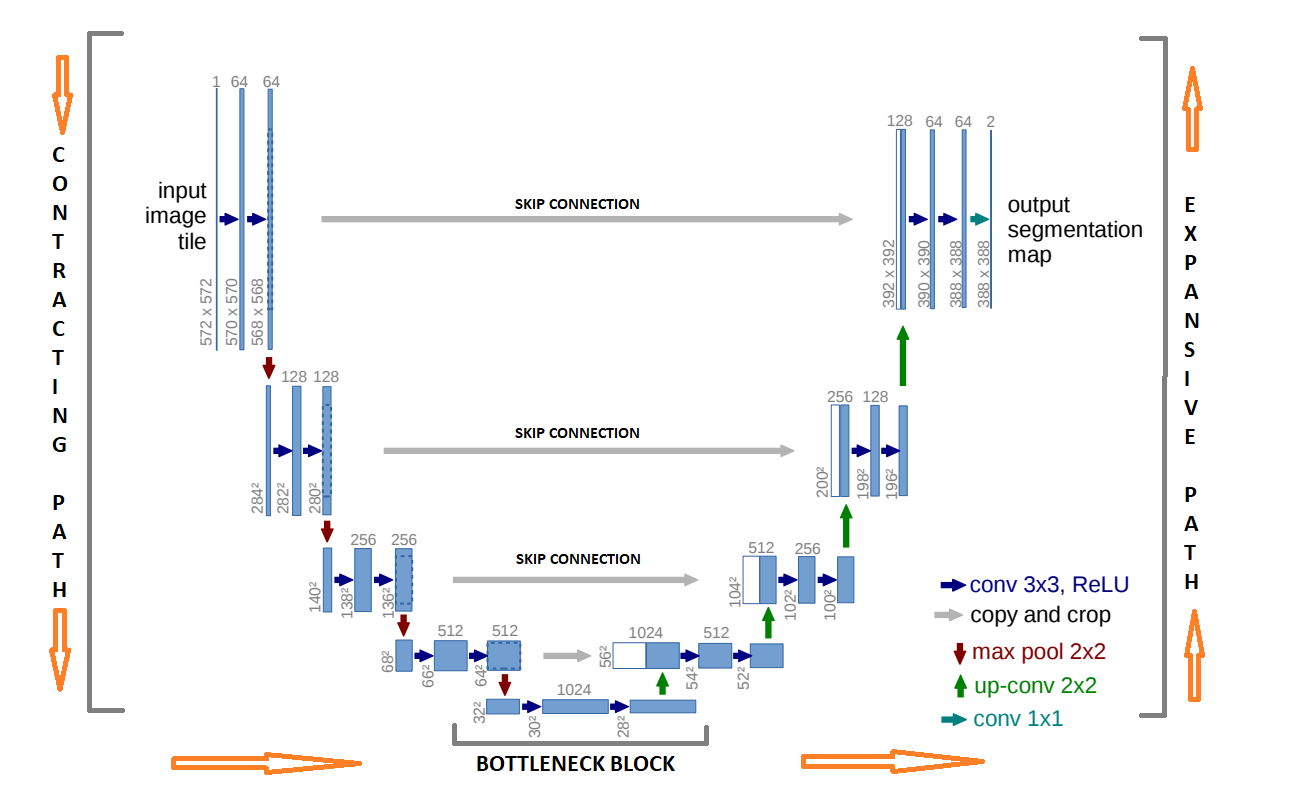

Image Reference - https://arxiv.org/pdf/1505.04597.pdf

### Original Paper Implementation
The original UNet model's implementation as described in the [paper](https://arxiv.org/pdf/1505.04597.pdf) can be found @ [UNet - Biomedical_Segmentation](https://github.com/sauravmishra1710/U-Net---Biomedical-Image-Segmentation/blob/main/UNet%20-%20Biomedical_Segmentation.ipynb)

### Applying UNet to a Realtime Dataset

#### Import Required Libraries and Utilities

In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt

from UNetDataGenerator import NucleiDataGenerator
from Unet import Unet

#### Define Implementation details, Dataset criteria and Model hyper parameters

In [2]:
image_size = 256
image_channels = 3
image_dir = "data-science-bowl-2018/stage1_train/"
epochs = 20
batch_size = 8

# there are a total of 670 items at the train_path directory.
# so fixing 600 of data available for training set
# 50 for validation set and 20 for test set.
validation_data_size = 50
test_data_size = 20
train_data_size = 600

#### Define Reusable Methods

In [3]:
def VisualizeImageAndMask(image, mask, prediction_img = None):
    
    """
    
    Displays the image, mask and the predicted mask
    of the input image.
    
    Args:
        image: the original image.
        mask: the given mask of the image.
        prediction_img: the predicted mask of the image.
        
    Return:
        None
        
    """
    fig = plt.figure()
    fig.subplots_adjust(hspace = 0.6, wspace = 0.6)
    fig.suptitle('Image & Mask(s)', fontsize = 15)
    fig.subplots_adjust(top = 1.15)
    
    ax = fig.add_subplot(1, 3, 1)
    ax.imshow(image)
    setTitleAndRemoveTicks(ax, 'Microscopic\nImage')
    
    ax = fig.add_subplot(1, 3, 2)
    ax.imshow(np.reshape(mask, (image_size, image_size)), cmap = "gray")
    setTitleAndRemoveTicks(ax, 'Original\nMask')
    
    if prediction_img is not None:
        ax = fig.add_subplot(1, 3, 3)
        ax.imshow(np.reshape(prediction_img, (image_size, image_size)), cmap = "gray")
        setTitleAndRemoveTicks(ax, 'Predicted\nMask')
    
def setTitleAndRemoveTicks(axes, title):
    
    """
    Sets the sub-plot title and removes the 
    x & y ticks on the respective axes.
    
    Args:
        axes: the subplot.
        title: title of the subplot.
        
    Return:
        None
        
    """
    
    # set plot title
    axes.title.set_text(title)
    
    # remove the ticks
    axes.set_xticks([])
    axes.set_yticks([])

#### Define Train, Test and Validation sets

In [4]:
# get the ids of the images.
# os.walk yields a 3-tuple (dirpath, dirnames, filenames). We need the directory names here.
# the name for parent of parent directory where the image is located and the name of the image are same.
# an example directory breakup is shown below -
# - data-science-bowl-2018/
#      - stage1_train/
#          - abc
#             - image
#                  - abc
#             - mask
image_ids = next(os.walk(image_dir))[1]

# partition the data into train, test and validation sets.
testing_data_ids = image_ids[:test_data_size]
validation_data_ids = image_ids[:validation_data_size]
training_data_ids = image_ids[:train_data_size]

#### Sample Data Visualization

In [5]:
temp_data_generator = NucleiDataGenerator(image_ids = training_data_ids, 
                                          img_path = image_dir, 
                                          batch_size = batch_size, 
                                          image_size = image_size)

# get one batch of data
images, masks = temp_data_generator.__getitem__(0)
print("Batch Dimension Details:", images.shape, masks.shape)

Batch Dimension Details: (8, 256, 256, 3) (8, 256, 256, 1)


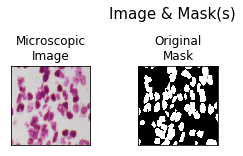

In [6]:
VisualizeImageAndMask(image = images[2], mask = masks[2])

In [7]:
temp_data_generator = None

### Model Training and Validation

#### Create UNet Model 

In [8]:
unet = Unet(input_shape = (image_size, image_size, image_channels), 
            filters = [16, 32, 64, 128, 256], 
            padding = "same")

# call the build netowrk API to build the network.
model = unet.Build_UNetwork()

In [9]:
# compile & summarize the model
if model is not None:
    unet.CompileAndSummarizeModel(model = model)

Model: "UNet"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 256, 256, 3) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 256, 256, 16) 448         input_1[0][0]                    
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 256, 256, 16) 2320        conv2d[0][0]                     
__________________________________________________________________________________________________
max_pooling2d (MaxPooling2D)    (None, 128, 128, 16) 0           conv2d_1[0][0]                   
_______________________________________________________________________________________________

#### Data Generators

In [10]:
train_gen = NucleiDataGenerator(image_ids = training_data_ids, 
                                img_path = image_dir, 
                                image_size = image_size, 
                                batch_size = batch_size)

valid_gen = NucleiDataGenerator(image_ids = validation_data_ids, 
                                img_path = image_dir, 
                                image_size = image_size, 
                                batch_size = batch_size)

test_gen = NucleiDataGenerator(image_ids = testing_data_ids, 
                               img_path = image_dir, 
                               image_size = image_size, 
                               batch_size = batch_size)

train_steps = len(training_data_ids)//batch_size
valid_steps = len(validation_data_ids)//batch_size

#### Model Training

In [11]:
model.fit(train_gen, 
          validation_data = valid_gen, 
          steps_per_epoch = train_steps, 
          validation_steps = valid_steps, 
          epochs = epochs)

Epoch 1/20
75/75 [==============================] - 348s 5s/step - loss: 0.3992 - acc: 0.8521 - val_loss: 0.2833 - val_acc: 0.8467
Epoch 2/20
75/75 [==============================] - 194s 3s/step - loss: 0.2117 - acc: 0.8880 - val_loss: 0.1691 - val_acc: 0.9294
Epoch 3/20
75/75 [==============================] - 201s 3s/step - loss: 0.1354 - acc: 0.9396 - val_loss: 0.2166 - val_acc: 0.9087
Epoch 4/20
75/75 [==============================] - 202s 3s/step - loss: 0.1179 - acc: 0.9477 - val_loss: 0.1395 - val_acc: 0.9340
Epoch 5/20
75/75 [==============================] - 202s 3s/step - loss: 0.1064 - acc: 0.9530 - val_loss: 0.1021 - val_acc: 0.9517
Epoch 6/20
75/75 [==============================] - 200s 3s/step - loss: 0.0887 - acc: 0.9590 - val_loss: 0.0978 - val_acc: 0.9528
Epoch 7/20
75/75 [==============================] - 204s 3s/step - loss: 0.0858 - acc: 0.9604 - val_loss: 0.1111 - val_acc: 0.9489
Epoch 8/20
75/75 [==============================] - 200s 3s/step - loss: 0.0803 - a

#### Save the Model

In [12]:
models_dir = "models\\"

if not os.path.isdir(models_dir):
    os.makedirs(models_dir)

model.save_weights(models_dir + "UNet.h5")

### Model Testing and Prediction Visualizations

In [13]:
# get the test set images
test_images, test_masks = test_gen.__getitem__(1)
predicted_masks = model.predict(test_images)

predicted_masks = predicted_masks > 0.5

#### Viz 1

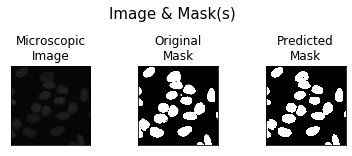

In [14]:
VisualizeImageAndMask(image = test_images[1], mask = test_masks[1], prediction_img = predicted_masks[1])

#### Viz 2

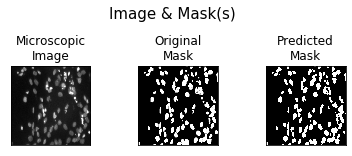

In [15]:
VisualizeImageAndMask(image = test_images[3], mask = test_masks[3], prediction_img = predicted_masks[3])

#### Viz 3

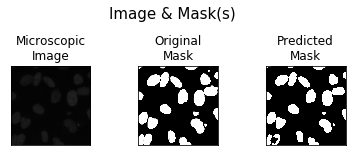

In [16]:
VisualizeImageAndMask(image = test_images[6], mask = test_masks[6], prediction_img = predicted_masks[6])

### Conclusion

Comparing the microscopic image, original mask and the predicted mask, it looks like the model is correctly able to segment the cell nuclei and generate the masks.

Though UNet was originally designed for bio-medical images, this model can be applied to any conputer vision segmentation task.